In [1]:
from util import locate_directory, get_image_T, calculate_gncc, get_cropped_image, get_image_CM
import deepreg.model.layer as layer
import glob
import h5py
import json
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def overlay_matrices(matrix1, matrix2, dim, contrast_factor=1, title="Image Overlay"):
    """
    Create a plot that overlays the MIPs of two matrices along a specified dimension.
    
    Parameters:
    - matrix1, matrix2 (np.array): 3D numpy arrays.
    - dim (int): The dimension along which to compute and overlay the MIPs.
    - contrast_factor (float): Factor by which to divide the maximum intensity 
                               to increase the image contrast. Must be >= 1.
    """
    # Ensure the matrices are 3D
    if matrix1.ndim != 3 or matrix2.ndim != 3:
        raise ValueError("Input matrices must be 3D")
    
    # Ensure contrast_factor is valid
    if contrast_factor < 1:
        raise ValueError("contrast_factor must be >= 1")
    
    # Compute MIPs
    mip1 = np.max(matrix1, dim)
    mip2 = np.max(matrix2, dim)
    
    # Ensure MIPs are 2D
    if mip1.ndim != 2 or mip2.ndim != 2:
        raise ValueError("MIPs must be 2D")
    
    # Normalize MIPs to [0, 1] based on the adjusted maximum values
    mip1_norm = mip1 / (np.max(mip1) / contrast_factor)
    mip2_norm = mip2 / (np.max(mip2) / contrast_factor)
    
    # Ensure values are clipped to [0, 1] after adjusting contrast
    mip1_norm = np.clip(mip1_norm, 0, 1)
    mip2_norm = np.clip(mip2_norm, 0, 1)
    
    # Create an RGB image: R corresponds to mip1, G to mip2, B is kept 0
    rgb_image = np.stack([mip1_norm, mip2_norm, np.zeros_like(mip1_norm)], axis=-1)
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the RGB image
    ax.imshow(rgb_image, origin='lower')
    
    # Add a title and show the plot
    ax.set_title(title)
    plt.show()

In [1]:
# ckpt = "20231103-104543_raw_filter-crop-v1_size-v2"
# ckpt = "20231031-120756_raw_crop-v1_size-v2"
# ckpt = "20231018-113705_euler-elastix_crop-v1"
ckpt = "20230822-132337_euler_ddf_epoch2000_ckpt2000"

base = "/home/alicia/data_personal/regnet_ckpt/logs_predict"
pair_num = 5
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

dataset_type_n_name = 'test/2022-04-14-04'
dataset_type, dataset_name = dataset_type_n_name.split('/')
data_path = locate_directory(dataset_name)

problem = '1062to1528'

t_moving, t_fixed = problem.split('to')

NameError: name 'os' is not defined

##### read in ROI images from source files 
##### transform ROI image with network outputted DDF

In [4]:
ddf_nii_path = f"{base}/{ckpt}/test/pair_{pair_num}/ddf.nii.gz"
ddf_array = nib.load(ddf_nii_path).get_fdata()

fixed_roi_image_path = f"{data_path}/img_roi_watershed/{t_fixed}.nrrd"
moving_roi_image_path = f"{data_path}/img_roi_watershed/{t_moving}.nrrd"

fixed_roi_image_T = get_image_T(fixed_roi_image_path)
moving_roi_image_T = get_image_T(moving_roi_image_path)

resized_fixed_roi_image = get_cropped_image(
        fixed_roi_image_T,
        (129, 31, 26), -1).astype(np.float32)
resized_moving_roi_image = get_cropped_image(
        moving_roi_image_T,
        (116, 32, 26), -1).astype(np.float32)

resized_fixed_roi_image_tf = tf.cast(tf.expand_dims(resized_fixed_roi_image,
    axis=0), dtype=tf.float32)
resized_moving_roi_image_tf = tf.cast(tf.expand_dims(resized_moving_roi_image,
    axis=0), dtype=tf.float32)

warping = layer.Warping(fixed_image_size=resized_fixed_roi_image_tf.shape[1:4],
                        interpolation="nearest")
warped_moving_roi_image_tf = warping(inputs=[ddf_array, resized_moving_roi_image_tf])
warped_moving_roi_image = warped_moving_roi_image_tf.numpy()[0]

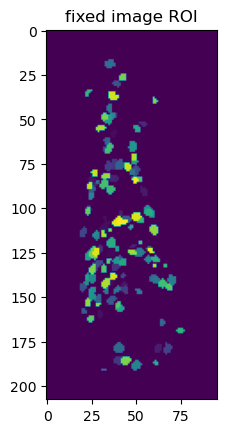

In [5]:
plt.imshow(resized_fixed_roi_image.max(2));
plt.title("fixed image ROI");

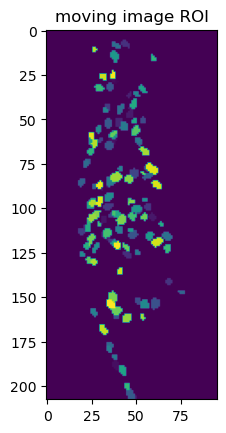

In [6]:
plt.imshow(resized_moving_roi_image.max(2));
plt.title('moving image ROI');

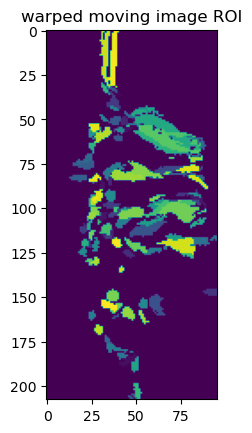

In [7]:
plt.imshow(warped_moving_roi_image.max(2));
plt.title("warped moving image ROI");

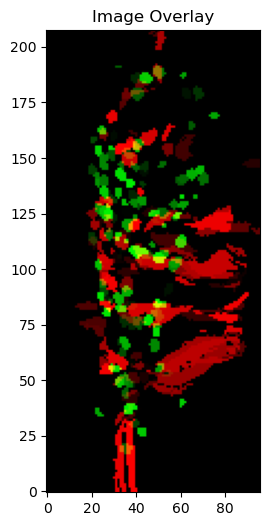

In [9]:
overlay_matrices(warped_moving_roi_image, resized_fixed_roi_image, 2)

##### read from network output directory

In [11]:
import glob

ddf_nii_path = f"{base}/{ckpt}/test/pair_{pair_num}/ddf.nii.gz"
ddf_array = nib.load(ddf_nii_path).get_fdata()

moving_image_nii_path = f"{base}/{ckpt}/test/pair_{pair_num}/moving_image.nii.gz"
moving_image = nib.load(moving_image_nii_path).get_fdata()

fixed_image_nii_path = f"{base}/{ckpt}/test/pair_{pair_num}/fixed_image.nii.gz"
fixed_image = nib.load(fixed_image_nii_path).get_fdata()

pred_fixed_image_nii_path = f"{base}/{ckpt}/test/pair_{pair_num}/pred_fixed_image.nii.gz"
pred_fixed_image = nib.load(pred_fixed_image_nii_path).get_fdata()

resized_fixed_image_tf = tf.cast(tf.expand_dims(fixed_image, axis=0), dtype=tf.float32)
resized_moving_image_tf = tf.cast(tf.expand_dims(moving_image, axis=0), dtype=tf.float32)

warping = layer.Warping(fixed_image_size=resized_fixed_image_tf.shape[1:4])
warped_moving_image_tf = warping(inputs=[ddf_array, resized_moving_image_tf])
warped_moving_image = warped_moving_image_tf.numpy()[0]

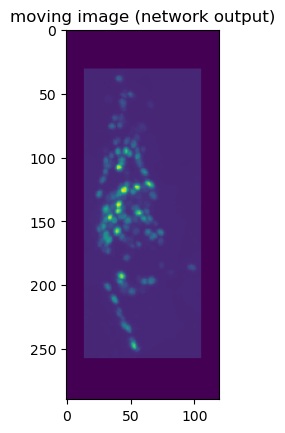

In [12]:
plt.imshow(moving_image.max(2));
plt.title("moving image (network output)");

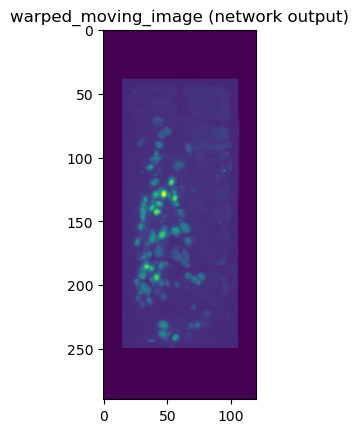

In [13]:
plt.imshow(warped_moving_image.max(2));
plt.title("warped_moving_image (network output)");

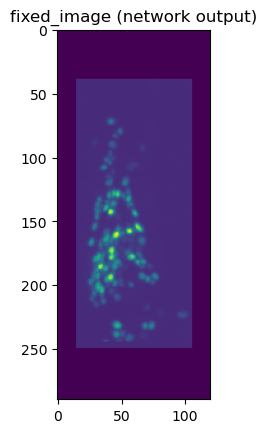

In [14]:
plt.imshow(fixed_image.max(2));
plt.title("fixed_image (network output)");

In [15]:
print(np.unique(warped_moving_image == pred_fixed_image))
print("warped moving image = predicted fixed image")

[ True]
warped moving image = predicted fixed image


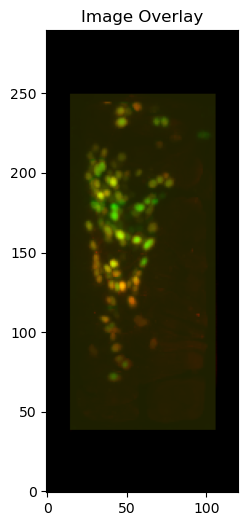

GNCC:  0.9857619923871154


In [16]:
overlay_matrices(warped_moving_image, fixed_image, 2)
print("GNCC: ", calculate_gncc(fixed_image, warped_moving_image))

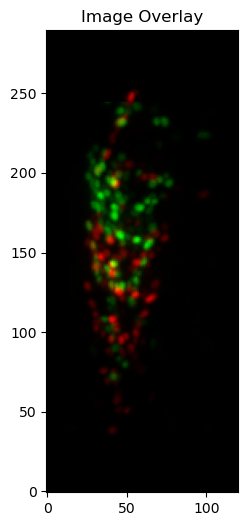

GNCC:  0.2142676475932429


In [14]:
overlay_matrices(moving_image, fixed_image, 2)
print("GNCC: ", calculate_gncc(fixed_image, moving_image))

##### read from source files

In [4]:
def filter_image(image, threshold):
    filtered_image = image - threshold
    filtered_image[filtered_image < 0] = 0
    return filtered_image

In [5]:
t_moving_4 = t_moving.zfill(4)
moving_image_source_path =  glob.glob(f"{data_path}/NRRD_filtered/*_t{t_moving_4}_ch2.nrrd")[0]
moving_image_source = get_image_T(moving_image_source_path)

moving_image_source_CM = get_image_CM(moving_image_source)
filtered_moving_image_source = filter_image(
        moving_image_source,
        np.median(moving_image_source)
)

resized_moving_image_source = get_cropped_image(
        #moving_image_source,
        filtered_moving_image_source,
        moving_image_source_CM, -1).astype(np.float32)
print(f"moving_image_source_CM: {moving_image_source_CM}")

t_fixed_4 = t_fixed.zfill(4)
fixed_image_source_path =  glob.glob(f"{data_path}/NRRD_filtered/*_t{t_fixed_4}_ch2.nrrd")[0]
fixed_image_source = get_image_T(fixed_image_source_path)

fixed_image_source_CM = get_image_CM(fixed_image_source)
filtered_fixed_image_source = filter_image(
        fixed_image_source,
        np.median(fixed_image_source)
)

resized_fixed_image_source = get_cropped_image(
        #fixed_image_source,
        filtered_fixed_image_source,
        fixed_image_source_CM, -1).astype(np.float32)
print(f"fixed_image_source_CM: {fixed_image_source_CM}")


moving_image_source_CM: (116, 32, 26)
fixed_image_source_CM: (129, 31, 26)


In [21]:
import matplotlib.pyplot as plt

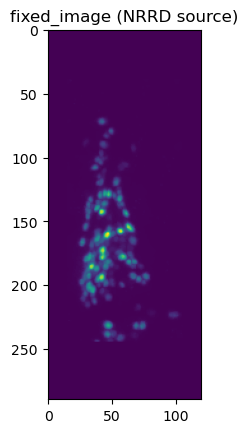

In [22]:
plt.imshow(resized_fixed_image_source.max(2));
plt.title("fixed_image (NRRD source)");

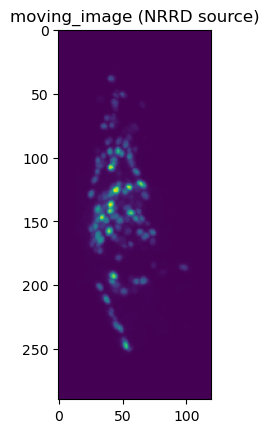

In [23]:
plt.imshow(resized_moving_image_source.max(2));
plt.title("moving_image (NRRD source)");

#### compare NRRD source images with network output

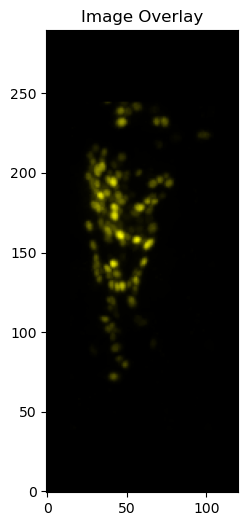

In [24]:
overlay_matrices(resized_fixed_image_source, fixed_image, 2)

In [25]:
np.unique(resized_fixed_image_source == fixed_image)

array([False,  True])

In [26]:
calculate_gncc(resized_fixed_image_source, fixed_image)

1.0000004123294446

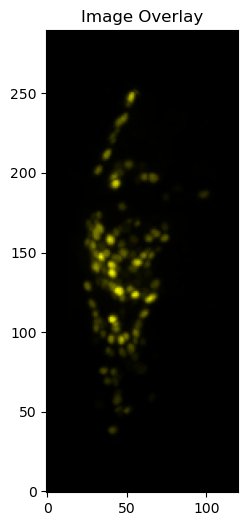

In [27]:
overlay_matrices(resized_moving_image_source, moving_image, 2)

In [28]:
np.unique(resized_moving_image_source == moving_image)

array([False,  True])

In [29]:
calculate_gncc(resized_fixed_image_source, resized_moving_image_source)

0.2142677

##### warp moving image (NRRD source) using DDF (network output)

In [19]:
ddf_nii_path = f"{base}/{ckpt}/test/pair_{pair_num}/ddf.nii.gz"
ddf_array = nib.load(ddf_nii_path).get_fdata()

resized_fixed_image_source_tf = tf.cast(tf.expand_dims(resized_fixed_image_source, axis=0), dtype=tf.float32)
resized_moving_image_source_tf = tf.cast(tf.expand_dims(resized_moving_image_source, axis=0), dtype=tf.float32)

warping = layer.Warping(fixed_image_size=resized_fixed_image_source_tf.shape[1:4])
warped_moving_image_source_tf = warping(inputs=[ddf_array, resized_moving_image_source_tf])
warped_moving_image_source = warped_moving_image_source_tf.numpy()[0]

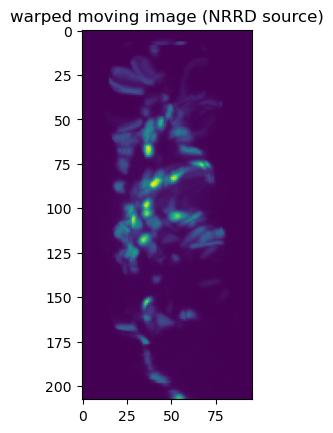

In [20]:
plt.imshow(warped_moving_image_source.max(2));
plt.title(f"warped moving image (NRRD source)");

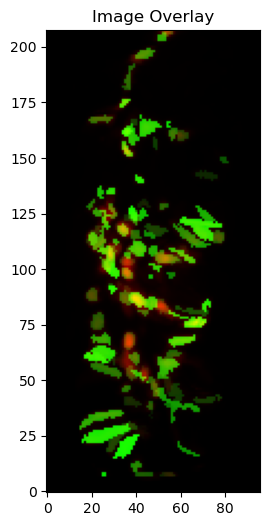

In [21]:
overlay_matrices(warped_moving_image_source, warped_moving_roi_image, 2)

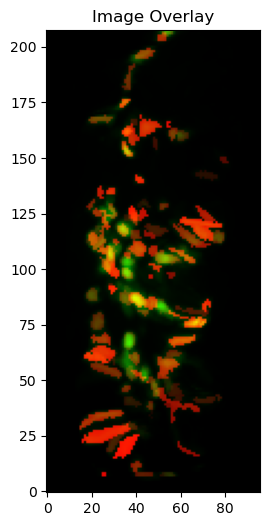

In [22]:
overlay_matrices(warped_moving_roi_image, warped_moving_image_source, 2)

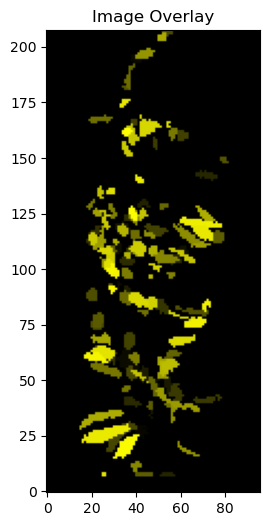

In [23]:
overlay_matrices(warped_moving_roi_image, warped_moving_roi_image, 2)

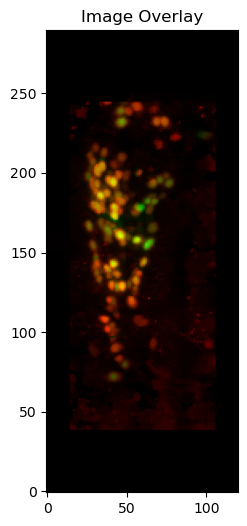

GNCC:  0.8454008


In [36]:
overlay_matrices(warped_moving_image_source, resized_fixed_image_source, 2)
print("GNCC: ", calculate_gncc(resized_fixed_image_source, warped_moving_image_source))

#### ROI image and moving image alignment

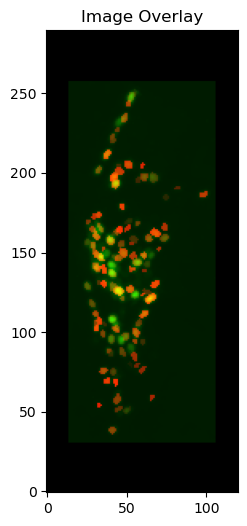

In [19]:
overlay_matrices(resized_moving_roi_image, moving_image, 2)

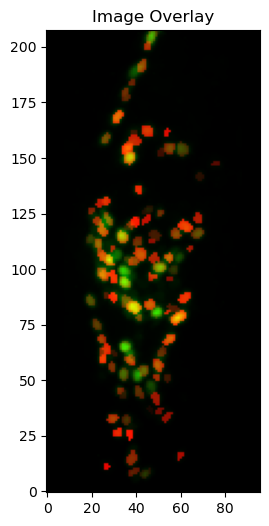

In [25]:
overlay_matrices(resized_moving_roi_image, resized_moving_image_source, 2)

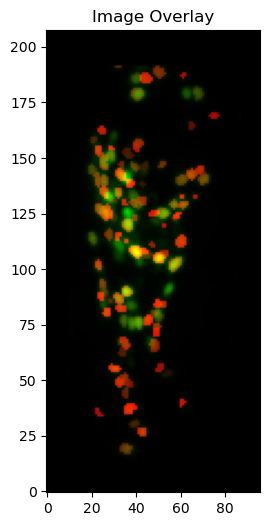

In [26]:
overlay_matrices(resized_fixed_roi_image, resized_fixed_image_source, 2)

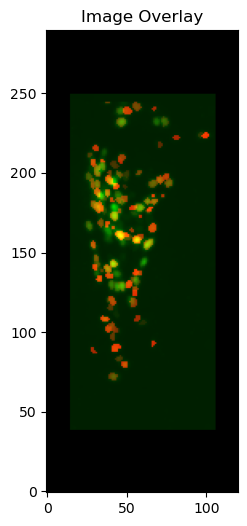

In [17]:
overlay_matrices(resized_fixed_roi_image, fixed_image, 2)

In [18]:
overlay_matrices(resized_moving_image_source, moving_image, 2)

NameError: name 'resized_moving_image_source' is not defined

#### examine the preprocessed inputs to the network

In [68]:

with open("jungsoo_registration_problems.json", "r") as f:
    registration_problem_dict = json.load(f)
print(registration_problem_dict.keys())
print(registration_problem_dict['test/2022-04-14-04'])

dict_keys(['train/2022-01-09-01', 'train/2022-01-23-04', 'train/2022-01-27-04', 'train/2022-06-14-01', 'train/2022-07-15-06', 'train/2022-01-17-01', 'train/2022-01-27-01', 'train/2022-03-16-02', 'train/2022-06-28-01', 'valid/2022-02-16-04', 'valid/2022-04-05-01', 'valid/2022-07-20-01', 'valid/2022-03-22-01', 'valid/2022-04-12-04', 'valid/2022-07-26-01', 'test/2022-04-14-04', 'test/2022-04-18-04', 'test/2022-08-02-01'])
['1013to1212', '1021to1049', '1023to1229', '1025to1026', '103to764', '1062to1528', '106to410', '1072to1511', '1073to1082', '1081to1142', '1118to1535', '1126to1127', '1134to1548', '116to1201', '1176to1496', '119to202', '119to792', '1264to1325', '1269to1339', '1281to1456', '1305to1325', '1367to1556', '1385to1419', '1388to1590', '13to1415', '156to199', '15to872', '169to460', '199to556', '205to243', '213to444', '225to310', '23to68', '245to539', '252to486', '261to588', '272to659', '279to1421', '28to534', '292to581', '301to745', '320to1136', '321to927', '327to793', '33to606', 

In [72]:
data_path = "/home/alicia/data_personal/regnet_dataset/2023-01-16_raw_crop-v1_size-v2"
# data_path = "/home/alicia/data_personal/regnet_dataset/raw_crop-filter_size-v2"

dataset_type_n_name = 'test/2022-04-14-04'
dataset_type, dataset_name = dataset_type_n_name.split('/')
problem = '1023to1229'
t_moving, t_fixed = problem.split('to')
t_moving_4 = t_moving.zfill(4)
t_fixed_4 = t_fixed.zfill(4)

fixed_image_path = f"{data_path}/{dataset_type}/{dataset_name}/fixed_images.h5"
moving_image_path = f"{data_path}/{dataset_type}/{dataset_name}/moving_images.h5"

fixed_image = h5py.File(fixed_image_path, 'r')[problem][:]
moving_image = h5py.File(moving_image_path, 'r')[problem][:]

# get corresponding raw images
dataset_path = locate_directory(dataset_name)
fixed_image_path = glob.glob(
        f'{dataset_path}/NRRD_filtered/*_t{t_fixed_4}_ch2.nrrd'
)[0]
moving_image_path = glob.glob(
        f'{dataset_path}/NRRD_filtered/*_t{t_moving_4}_ch2.nrrd'
)[0]

fixed_image_T = get_image_T(fixed_image_path)
moving_image_T = get_image_T(moving_image_path)

(290, 120, 64)


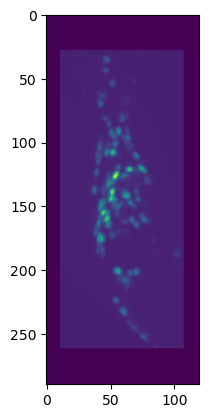

In [73]:
plt.imshow(moving_image.max(2));
print(moving_image.shape)

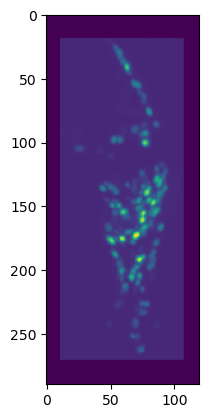

In [74]:
plt.imshow(fixed_image.max(2));

(211, 173, 60)


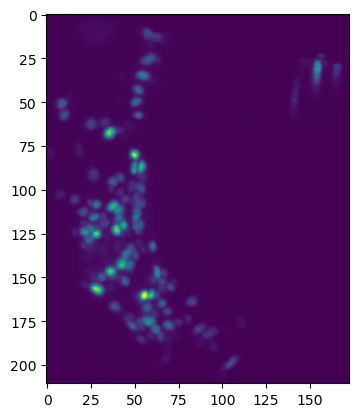

In [27]:
# plt.imshow(fixed_image_T.max(2));
plt.imshow(moving_image_T.max(2));
print(moving_image_T.shape)